In [15]:
%matplotlib inline

from modsim import *

In [61]:
tc_h= 3
tc_m=2
tc_nm=1         #time between contacts in days
tr=4        #recovery time in days
th=2         #time sick but appear healthy in days

beta_h=1/tc_h
beta_m=1/tc_m
beta_nm=1/tc_nm      #contact rate in per day
gamma=1/tr      #recovery rate in per day
omega=1/th      #sick appearance rate in per day

alpha = .1  #percent of sick people who take medicine
alpha_array = linspace(0.1, 0.9, 11)

credits = 16
hours_expected = credits * 3

hours_s = 48
hours_i_h = 48
hours_i_nm = 12
hours_i_m = 30
hours_r = 48

total_hours_expected = hours_expected * 350

In [62]:
def make_system(beta_h, beta_m, beta_nm, gamma, omega, alpha):
    """Make a system object for the SIR model.
    
    beta: contact rate in days
    gamma: recovery rate in days
    
    returns: System object
    """
    init = State(S=349, I_H=1, I_M=0, I_NM=0, R=0)
    init /= np.sum(init)
    
    initE = State(Se=349 * 48, I_He=1 * 48, I_Me=0, I_NMe=0, Re=0, Efficiancy = 0)
    
    t0 = 0
    t_end = 7 * 14

    return System(init=init, initE=initE, t0=t0, t_end=t_end,
                  beta_h=beta_h, beta_m=beta_m, beta_nm=beta_nm, gamma=gamma, omega=omega, alpha=alpha)

In [63]:
def plot_results(S, I_H, I_M, I_NM, R):
    """Plot the results of a SIR model.
    
    S: TimeSeries
    I: TimeSeries
    I_H: TimeSeries
    I_U: TimeSeries
    R: TimeSeries
    """
    plot(S, '--', color='blue', label='s')
    plot(I_H, '-', color='red', label='i_h')
    plot(I_M, '-', color='purple', label='i_m')
    plot(I_NM, '-', color='orange', label='i_nm')
    plot(R, ':', color='green', label='r')
    decorate(xlabel='Time (days)',
             ylabel='Fraction of population')

In [64]:
def calc_total_infected(system):
    """Fraction of population infected during the simulation.
    
    system: System object with results.
    
    returns: fraction of population
    """
    frame = system.results
    return frame.S[system.t0] - frame.S[system.t_end]

In [65]:
def calculate_efficiancy(stateE, stateP, system):
    
    Se, I_He, I_Me, I_NMe, Re, Efficiancy = stateE
    
    s, i_h, i_m, i_nm, r = stateP
        
    Se = (hours_s) * s * 350
    I_He = (hours_i_h) * i_h * 350
    I_Me = (hours_i_m) * i_m * 350
    I_NMe = (hours_i_nm) * i_nm * 350
    Re = (hours_r) * r * 350  
    
    Efficiancy = total_hours_expected - Se - I_He - I_Me - I_NMe - Re 
    
    return State(Se=Se, I_He=I_He, I_Me=I_Me, I_NMe=I_NMe, Re=Re, Efficiancy=Efficiancy)

In [66]:
"""def calculate_efficiancy(stateE, stateP, stateH, system):
    
    Se, I_He, I_Me, I_NMe, Re = stateE
    
    s, i_h, i_m, i_nm, r = stateP
    
    Total_Hours_Exp = stateH
    
    Se = (hours_s) * s * 350
    I_He = (hours_i_h) * i_h * 350
    I_Me = (hours_i_m) * i_m * 350
    I_NMe = (hours_i_nm) * i_nm * 350
    Re = (hours_r) * r * 350
    
    Total_Hours_Exp = total_hours_expected - Se - I_He - I_Me - I_NMe - Re    
    
    return State(HT=Total_Hours_Exp)"""

'def calculate_efficiancy(stateE, stateP, stateH, system):\n    \n    Se, I_He, I_Me, I_NMe, Re = stateE\n    \n    s, i_h, i_m, i_nm, r = stateP\n    \n    Total_Hours_Exp = stateH\n    \n    Se = (hours_s) * s * 350\n    I_He = (hours_i_h) * i_h * 350\n    I_Me = (hours_i_m) * i_m * 350\n    I_NMe = (hours_i_nm) * i_nm * 350\n    Re = (hours_r) * r * 350\n    \n    Total_Hours_Exp = total_hours_expected - Se - I_He - I_Me - I_NMe - Re    \n    \n    return State(HT=Total_Hours_Exp)'

In [67]:
def run_simulation(system, update_func, eff_func):
    """Runs a simulation of the system.
    
    Add a TimeFrame to the System: results
    
    system: System object
    update_func: function that updates state
    """
    
    frame = TimeFrame(columns=system.init.index)
    frame.loc[system.t0] = system.init
    
    eff = TimeFrame(columns=system.initE.index)
    eff.loc[system.t0] = system.initE
    
    
    for i in linrange(system.t0, system.t_end):
        frame.loc[i+1] = update_func(frame.loc[i], system)
        eff.loc[i+1] = eff_func(eff.loc[i], frame.loc[i], system) 
        
        
    system.results = frame
    system.resultsE = eff 

In [68]:
def update1(state, system):
    """Update the SIR model.
    
    state: State (s, i, r)
    system: System object
    
    returns: State (sir)
    """

    s, i_h, i_m, i_nm, r = state

    # Infected-Healthy
    #still_IH = i_h * omega
    new_IH = s * ((i_h * system.beta_h) + (i_m * system.beta_m) + (i_nm * system.beta_nm))
    #infected_Healthy = still_IH + new_IH
    
    # Infected-Medicine
    #still_IM = (1-gamma)*i_m
    new_IM = system.alpha * i_h * (system.omega)
    #infected_Med = still_IM + new_IM
    
    # Infected-NoMedicine
    #stillNM = (1-gamma)*i_nm
    newNM = (1 - system.alpha)*i_h*(system.omega)
    #infected_No_Med = stillNM + newNM
    
    recovered = system.gamma * (i_m + i_nm)
    
    s -= new_IH
    i_h +=  new_IH - newNM - new_IM
    i_m += new_IM - (recovered * system.alpha)
    i_nm += newNM - (recovered*(1 - system.alpha))
    r += recovered
    
    return State(S=s, I_H=i_h, I_M=i_m, I_NM=i_nm, R=r)

In [69]:
system = make_system(beta_h, beta_m, beta_nm, gamma, omega, alpha)
run_simulation(system, update1, calculate_efficiancy)
system.resultsE

,Se,I_He,I_Me,I_NMe,Re,Efficiancy
0,16752.000000,4.800000e+01,0.000000e+00,0.000000,0.000000,0.000000
1,16752.000000,4.800000e+01,0.000000e+00,0.000000,0.000000,0.000000
2,16736.045714,3.995429e+01,1.500000e+00,5.400000,0.000000,17.100000
3,16700.065114,5.595774e+01,2.373571e+00,8.544857,6.000000,27.058714
4,16645.659813,8.238417e+01,3.528858e+00,12.703889,15.494286,40.228982
5,16565.304839,1.215471e+02,5.221149e+00,18.796136,29.609718,59.521098
6,16447.102367,1.789760e+02,7.714207e+00,27.771146,50.494314,87.941963
7,16273.903984,2.626864e+02,1.137866e+01,40.963160,81.351143,129.716673
8,16021.544465,3.837027e+02,1.674294e+01,60.274588,126.865765,190.869530
9,15656.869690,5.565261e+02,2.454792e+01,88.372496,193.837530,279.846238


Saving figure to file sim-run.pdf


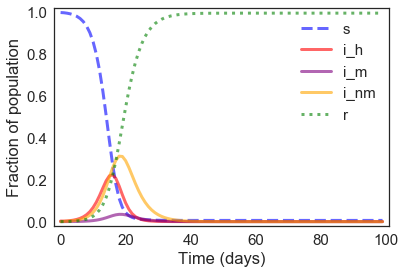

In [70]:
frame = system.results
plot_results(frame.S, frame.I_H, frame.I_M, frame.I_NM, frame.R)
savefig('sim-run.pdf')

In [71]:
def plot_results2(Efficiancy):
    """Plot the results of a SIR model.
    
    S: TimeSeries
    I: TimeSeries
    I_H: TimeSeries
    I_U: TimeSeries
    R: TimeSeries
    """
    plot(Efficiancy, '--', color='blue', label='E')
    decorate(xlabel='Time (days)',
             ylabel='Time Lost (Hours)')

Saving figure to file Hours-Lost.pdf


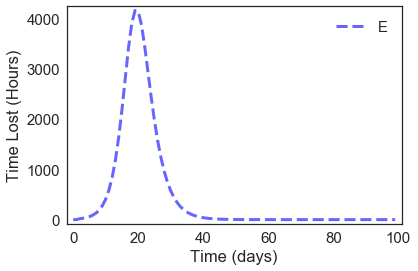

In [72]:
eff = system.resultsE
plot_results2(eff.Efficiancy)
savefig('Hours-Lost.pdf')

In [58]:
def add_hours(column):
    total = 0
    i = 0
    for hours in column:
        total += hours
    return total

In [59]:
def sweep_alpha(beta_h, beta_m, beta_nm, gamma, omega, alpha_array):
    """SweepSeriess a range of values for alpha.
    
    alpha_array: array of alpha values
    gamma: recovery rate
    
    returns: SweepSeries that maps from beta to total infected
    """
    sweep = SweepSeries()
    for alpha in alpha_array:
        system = make_system(beta_h, beta_m, beta_nm, gamma, omega, alpha)
        run_simulation(system, update1, calculate_efficiancy)
        sweep[system.alpha] = add_hours(system.resultsE.Efficiancy)
    return sweep

In [60]:
efficiancy_sweep = sweep_alpha(beta_h, beta_m, beta_nm, gamma, omega, alpha_array)
efficiancy_sweep

,value
0.10,47606.114324
0.18,45529.226834
0.26,43441.489160
0.34,41341.464461
0.42,39227.607722
0.50,37098.273508
0.58,34951.730001
0.66,32786.182255
0.74,30599.809112
0.82,28390.820568


C:\ProgramData\Miniconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


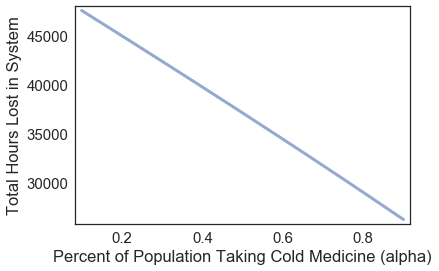

In [175]:
plot(efficiancy_sweep)
decorate(xlabel='Percent of Population Taking Cold Medicine (alpha)',
         ylabel='Total Hours Lost in System')